## 합성곱 신경망

### 파이토치로 Fashion MNIST CNN 실습
- 텐서플로(케라스)로 CNN을 하든, 파이토치로 CNN을 하든 아무 차이가 없음.

#### 데이터셋 불러오기

In [17]:
# 사용모듈 로드
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

In [18]:
# 이전에는 sklearn에 있는 StandardScaler 사용
# 정규화 및 텐서 변환
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))  # Fashion-MNIST 자주 사용하는 정규화 범위
])

# Fashion-MNIST를 Dataset으로 변경
## keras는 C:\Users\Admin\.keras\datasets
## PyTorch는 현재위치에 다운로드
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform)

# Dataset을 Dataloader로 변경
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

#### 클래스 레이블

|레이블|0|1|2|3|4|5|6|7|8|9|
|:---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|패션MNIST|티셔츠|바지|스웨터|드레스|코드|샌달|셔츠|스니커즈|가방|앵클 부츠|

#### CNN 모델 정의

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)       # 2x2 최대풀링 / 사이즈 반으로 줄이는 것
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)   # 28x28 -> 14x14 -> 7x7
        self.fc2 = nn.Linear(128,10)    # 10개 클래스(0~9까지)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))    # conv1을 통과시키고 relu활성화를 하고 MaxPool -> 14x14 특성맵
        x = self.pool(F.relu(self.conv2(x)))    # conv2을 통과시키고 relu활성화를 하고 MaxPool -> 7x7 특성맵 
        x = x.view(-1, 64*7*7)                  # flatten -> 1차원 배열화
        x = F.relu(self.fc1(x))                 # Dense layer 통과, relu활성화
        x = self.fc2(x)                         # F,softmax() depreacated됨
        return x
## Keras CNN과 완전 일치    

#### 훈련/평가 루프

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # 학습률 0.01 -> 0.001로 조정

In [21]:
# 훈련함수
def train(model, dataloader, criterion, optimizer):
    model.train() # 훈련모드
    total_loss = 0

    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)    

In [22]:
# 검증(평가)함수
def evaluate(model, dataloader, criterion):
    model.eval()    # 검증모드
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():   # 평가시에는 그레디언트 꺼줌
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()

            # 정확도
            preds = torch.argmax(outputs, dim=1)    # 제일 확률이 큰 값의 인덱스(0,1,2)중 하나 값 선택
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    return total_loss / len(dataloader), correct / total    

#### 훈련 실행

In [23]:
EPOCH = 10

for epoch in range(EPOCH):
    train_loss = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(f'[{epoch+1}/ {EPOCH}] Train Loss : {train_loss:.3f} | Val Loss : {val_loss:.3f}, Val_Accuracy : {val_acc:.2%}')

[1/ 10] Train Loss : 0.435 | Val Loss : 0.331, Val_Accuracy : 88.26%
[2/ 10] Train Loss : 0.278 | Val Loss : 0.279, Val_Accuracy : 89.83%
[3/ 10] Train Loss : 0.233 | Val Loss : 0.262, Val_Accuracy : 90.71%
[4/ 10] Train Loss : 0.203 | Val Loss : 0.242, Val_Accuracy : 91.49%
[5/ 10] Train Loss : 0.178 | Val Loss : 0.251, Val_Accuracy : 91.08%
[6/ 10] Train Loss : 0.154 | Val Loss : 0.240, Val_Accuracy : 92.03%
[7/ 10] Train Loss : 0.134 | Val Loss : 0.243, Val_Accuracy : 92.03%
[8/ 10] Train Loss : 0.113 | Val Loss : 0.248, Val_Accuracy : 92.19%
[9/ 10] Train Loss : 0.096 | Val Loss : 0.280, Val_Accuracy : 91.65%
[10/ 10] Train Loss : 0.083 | Val Loss : 0.289, Val_Accuracy : 91.98%


#### 원본데이터 시각화

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# 한글로 Matplotlib 사용시 항상 필요
from matplotlib import rcParams, font_manager, rc

font_path = 'C:/Windows/Fonts/malgun.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
rcParams['axes.unicode_minus'] = False

sns.set_style('darkgrid')
sns.set_theme(font='Malgun Gothic', rc={'axes.unicode_minus': False})

In [26]:
class_names = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', '앵클부츠']

In [ ]:
# 데이터로더에서 하나만 꺼내기
dataloader = DataLoader(train_dataset, batch_size=9, shuffle=True)
images, labels = next(iter(dataloader)) # 배치 하나만 추출(9개 생성)

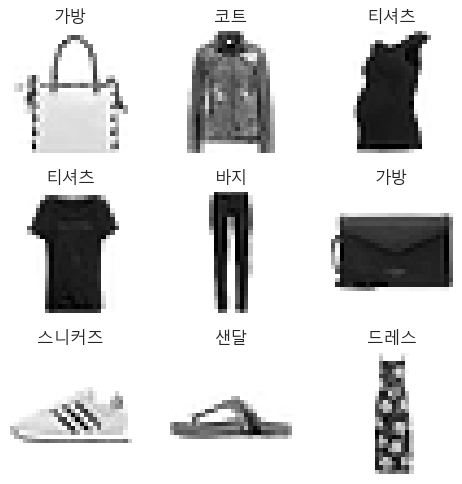

In [34]:
plt.figure(figsize=(5,5))

for i in range(9):
    plt.subplot(3,3, i+1)
    plt.imshow(images[i][0], cmap = 'gray_r')
    plt.axis('off')
    plt.title(class_names[labels[i]])

plt.tight_layout()
plt.show()    



#### 예측결과 시각화

In [35]:
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

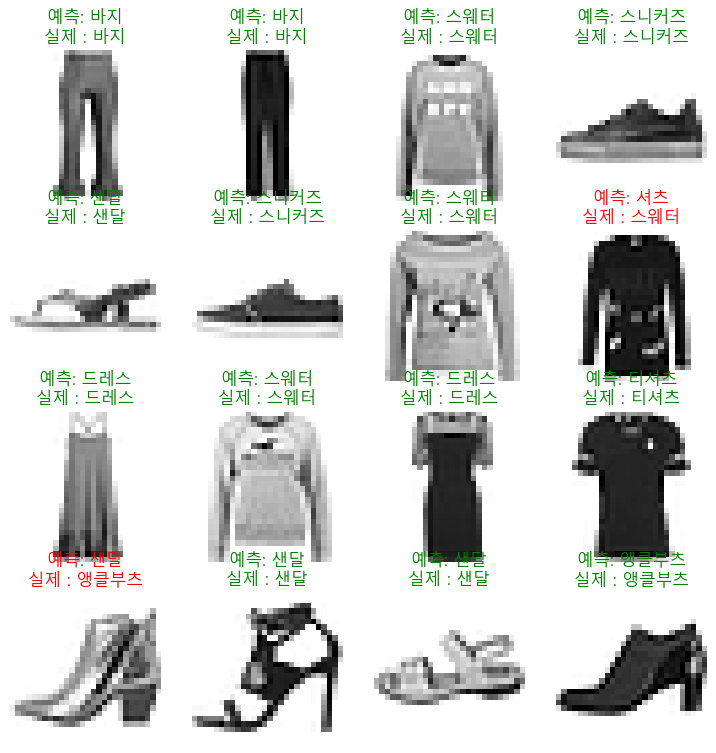

In [43]:
# 테스트 배치 하나만 가져오기
images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)  # 모델에 처리하려면 항상 cuda 전달 

# 모델을 검증모드
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# 예측값 시각화. 시각화 때는 CUDA를 못씀
plt.figure(figsize = (9,9))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i].cpu().squeeze(), cmap='grey_r')    # cuda로 전달되었던 images를 다시 cpu로 이동
    plt.axis('off')
    plt.title(f'예측: {class_names[preds[i]]}\n실제 : {class_names[labels[i]]}', color = 'green' if preds[i] == labels[i] else 'red')

#### 모델 저장 및 로드
- 가중치만 저장

In [44]:
# 가중치 저장
torch.save(model.state_dict(), './fashion_mnist_cnn.pth') # pytorch의 모델확장자 pth

In [ ]:
# 가중치 저장시는 모델은 직접 생성해야 함
model2 = CNN().to(device) # 객체 생성
model2.load_state_dict(torch.load('./fashion_mnist_cnn.pth', map_location=device))
model2

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

- 전체 모델 저장

In [ ]:
# 전체 모델 저장
torch.save(model, './fashion_mnist_full.pth')

In [50]:
# 전체 모델 로드
model3 = torch.load('./fashion_mnist_full.pth', weights_only=False)
model3

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)